In [12]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


In [ ]:
if os.path.exists('/Users/gaomin/Desktop/QT/DashForCash/data') == True:
    data_folder = '/Users/gaomin/Desktop/QT/DashForCash/data'
    os.chdir(data_folder)   
else:
    print('invalid data path!')

## Get the S&P500 return and macronews announcement data

In [64]:
con = duckdb.connect()

# get the interest rate data
cfo = pd.read_excel('/Users/gaomin/Desktop/QT/DashForCash/data/FOCM.xlsx')
cfo.drop_duplicates(subset=['Date'],keep='first',inplace=True)
# get the S&P500 return
query = ("""
    SELECT 
    permno,
    siccd as industry,
    CAST(dlycaldt AS TIMESTAMP) AS Date ,
    dlyprc    AS price,
    dlyret    AS ret,
    shrout    AS shares_outstanding,
    (shrout * dlyprc) AS market_cap,
    dlybid    AS bid,
    dlyask    AS ask,
    dlyvol    AS volume,
    dlyprcvol AS price_volume,
    dlyhigh   AS high,
    dlylow    AS low
FROM read_parquet('/Users/gaomin/Desktop/QT/crsp_202401.dsf_v2.parquet')
WHERE dlycaldt BETWEEN '1997-04-01' AND '2025-01-31' AND permno = 84398

""")
sp = con.execute(query).df()

# loading the NFP data
nfp = pd.read_excel('//Users/gaomin/Desktop/QT/data/Unemployment.xlsx')
nfp = nfp[nfp['Event']== 'Change in Nonfarm Payrolls'].sort_values('Date Time')
nfp['Date'] = pd.to_datetime(nfp['Date Time']).dt.date
nfp = nfp[['Date', 'Actual', 'Surv(A)', 'Surprise', 'Prior']].drop_duplicates()
nfp = nfp.rename(columns={
    'Surv(A)': 'Survey_Value',
    'Actual': 'Actual_Value'
})
nfp['Announcement_Type'] = 'NFP'
nfp['Survey_Value'] = pd.to_numeric(nfp['Survey_Value'], errors='coerce')
nfp['Actual_Value'] = pd.to_numeric(nfp['Actual_Value'], errors='coerce')
nfp['Prior'] = pd.to_numeric(nfp['Prior'], errors='coerce')

# difference between the expected and prior values, shows the current market prediction
nfp['nfp_diff_expected'] = nfp['Survey_Value'] - nfp['Prior']
# difference between the actual and prior values, shows the surprise
nfp['nfp_diff_actual'] = nfp['Actual_Value'] - nfp['Prior']

# difference between the actual and expected values
nfp['nfp_diff'] = nfp['Actual_Value'] - nfp['Survey_Value']


con.register('cfo', cfo)
con.register("sp",sp)
con.register("nfp",nfp)


# combine the S&P500 return and interest rate data
query = """
with base_calculations AS (
    SELECT 
        Date,
        ret as daily_return,
        LAG(ret, 1) OVER (ORDER BY Date) as last_day1_return,
        LAG(ret, 2) OVER (ORDER BY Date) as last_day2_return,   
        LAG(ret, 3) OVER (ORDER BY Date) as last_day3_return,
        LAG(ret, 4) OVER (ORDER BY Date) as last_day4_return,
        LAG(ret, 5) OVER (ORDER BY Date) as last_day5_return,
        LEAD(ret, 1) OVER (ORDER BY Date) as next_day1_return,
        LEAD(ret, 2) OVER (ORDER BY Date) as next_day2_return,
        LEAD(ret, 3) OVER (ORDER BY date) as next_day3_return,
        LEAD(ret, 4) OVER (ORDER BY date) as next_day4_return,
        LEAD(ret, 5) OVER (ORDER BY date) as next_day5_return
    FROM sp
)
SELECT  
    cfo."Date",
    LAG(cfo."Actual") OVER (ORDER BY cfo."Date") - cfo."Actual" as difference,
    base_calculations."daily_return",
    base_calculations."next_day1_return",
    base_calculations."next_day2_return",
    base_calculations."next_day3_return",   
    base_calculations."next_day4_return",
    base_calculations."next_day5_return",
    base_calculations."last_day1_return",
    base_calculations."last_day2_return",
    base_calculations."last_day3_return",
    base_calculations."last_day4_return",
    base_calculations."last_day5_return",
    CASE 
        WHEN TRIM("Surv(A)") IN ('--', '') THEN NULL
        WHEN TRY_CAST("Surv(A)" AS DOUBLE) IS NOT NULL THEN "Actual" - CAST("Surv(A)" AS DOUBLE)
        ELSE NULL
    END as premium_A,
    CASE 
        WHEN TRIM("Surv(M)") IN ('--', '') THEN NULL
        WHEN TRY_CAST("Surv(M)" AS DOUBLE) IS NOT NULL THEN "Actual" - CAST("Surv(M)" AS DOUBLE)
        ELSE NULL
    END as premium_M
FROM cfo
LEFT JOIN base_calculations
ON cfo.Date = base_calculations.date
"""
df = con.execute(query).df()

# combine the S&P500 return and nfp data
query = """
with base_calculations AS (
    SELECT 
        Date,
        ret as daily_return,
        LAG(ret, 1) OVER (ORDER BY Date) as last_day1_return,
        LAG(ret, 2) OVER (ORDER BY Date) as last_day2_return,   
        LAG(ret, 3) OVER (ORDER BY Date) as last_day3_return,
        LAG(ret, 4) OVER (ORDER BY Date) as last_day4_return,
        LAG(ret, 5) OVER (ORDER BY Date) as last_day5_return,
        LEAD(ret, 1) OVER (ORDER BY Date) as next_day1_return,
        LEAD(ret, 2) OVER (ORDER BY Date) as next_day2_return,
        LEAD(ret, 3) OVER (ORDER BY date) as next_day3_return,
        LEAD(ret, 4) OVER (ORDER BY date) as next_day4_return,
        LEAD(ret, 5) OVER (ORDER BY date) as next_day5_return
    FROM sp
)
SELECT  
    nfp."Date",
    nfp.nfp_diff,
    base_calculations."daily_return",
    base_calculations."next_day1_return",
    base_calculations."next_day2_return",
    base_calculations."next_day3_return",   
    base_calculations."next_day4_return",
    base_calculations."next_day5_return",
    base_calculations."last_day1_return",
    base_calculations."last_day2_return",
    base_calculations."last_day3_return",
    base_calculations."last_day4_return",
    base_calculations."last_day5_return",
FROM nfp
LEFT JOIN base_calculations
ON nfp.Date = base_calculations.date
"""
df_nfp = con.execute(query).df()

## Analysis the relationship between the surprise of interest rate and market return

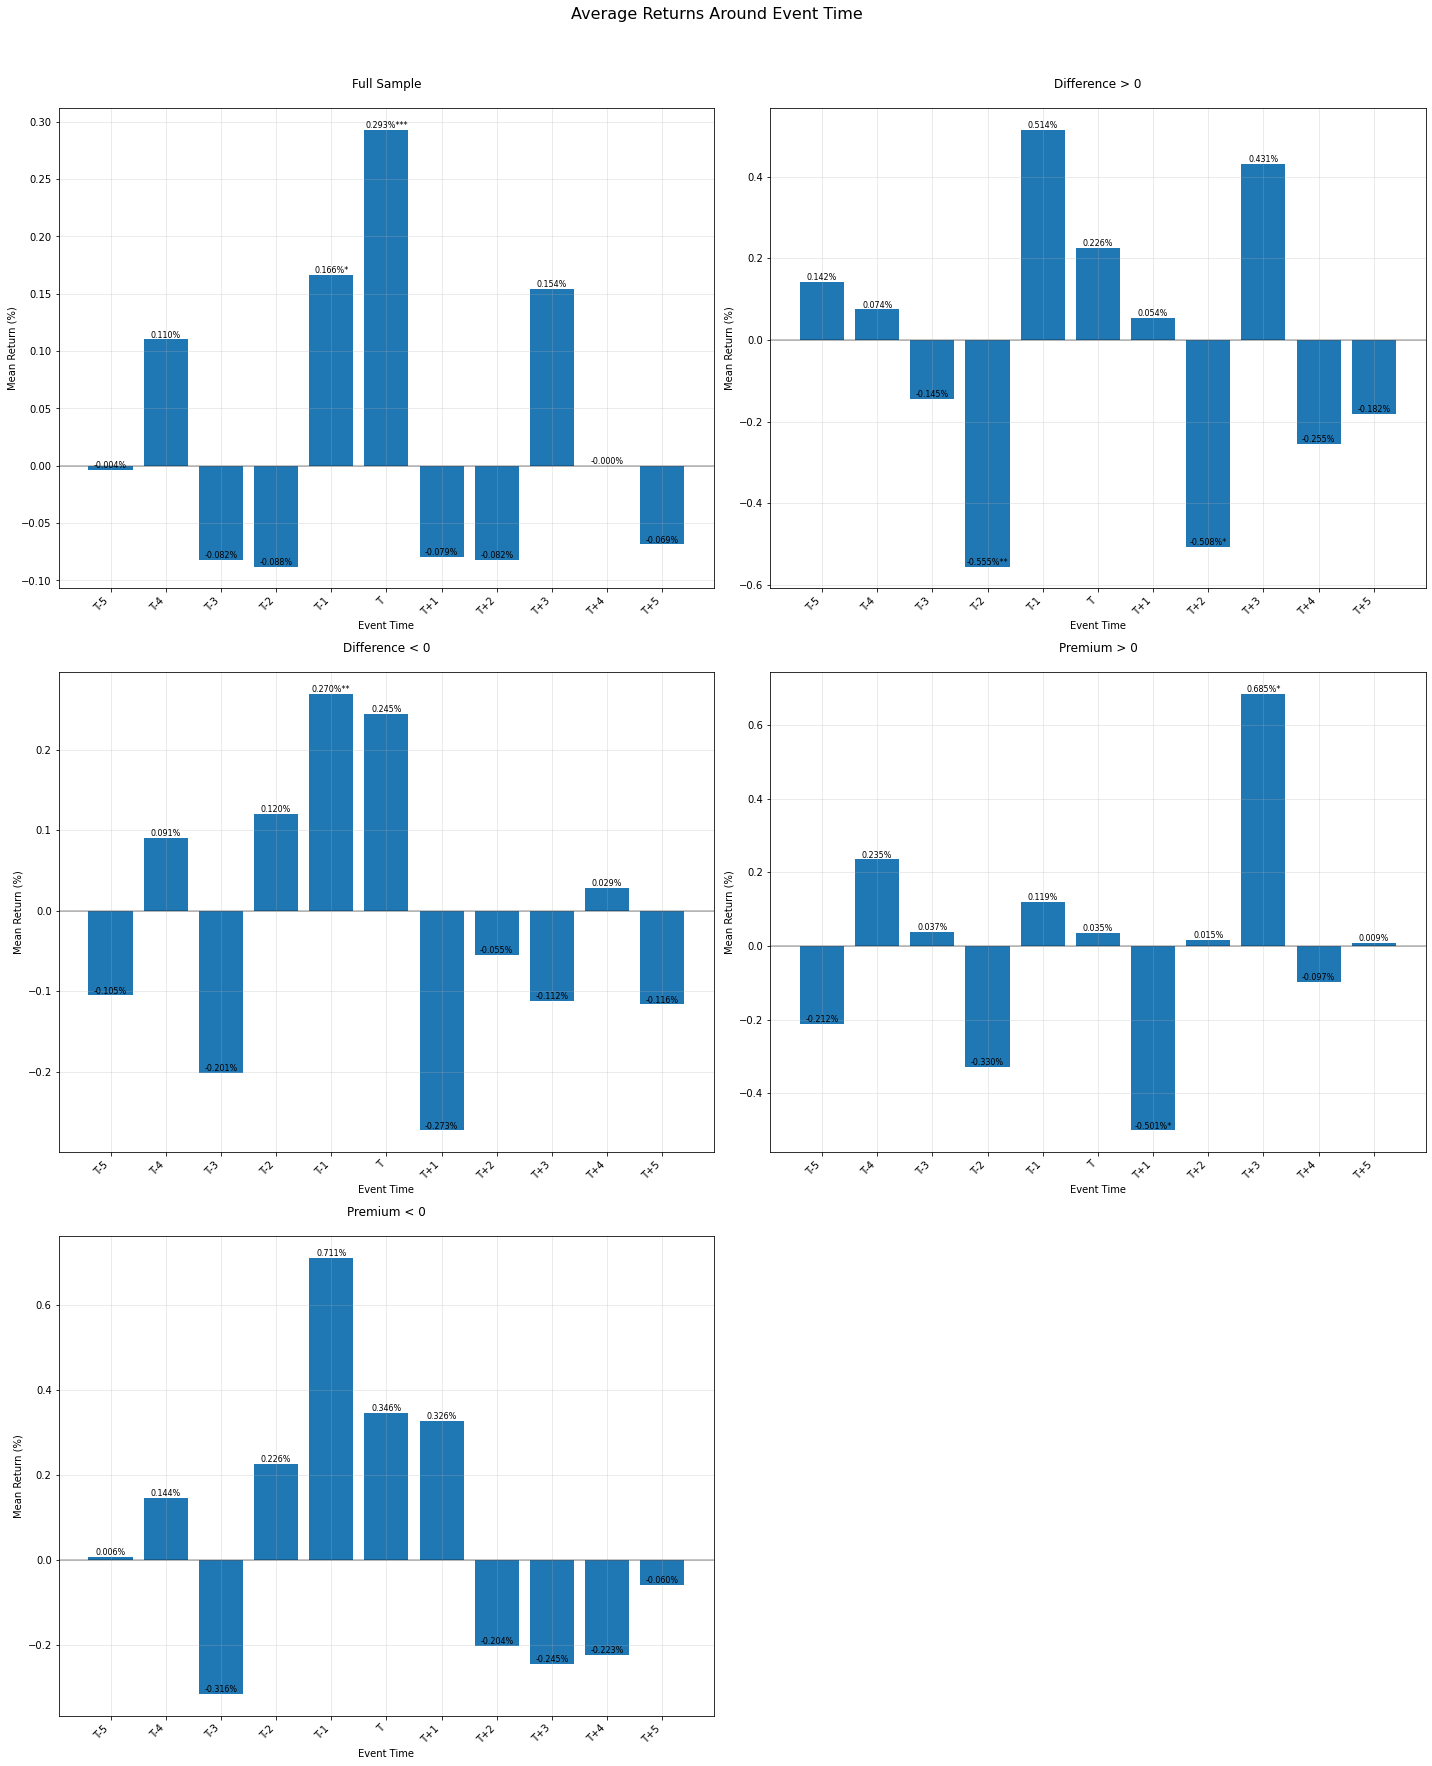


Full Sample:
      Mean Return    Std Dev      N t-statistic p-value
T-5    -0.003548%  1.130739%  220.0     -0.0465  0.9629
T-4     0.110159%  1.007219%  220.0      1.6222  0.1062
T-3    -0.082096%  1.295502%  220.0     -0.9399  0.3483
T-2    -0.087965%  1.047759%  220.0     -1.2453  0.2144
T-1    0.166356%*  1.425454%  220.0      1.7310  0.0849
T    0.292740%***  1.371743%  220.0      3.1653  0.0018
T+1    -0.079197%  1.494144%  220.0     -0.7862  0.4326
T+2    -0.082090%  1.123369%  220.0     -1.0839  0.2796
T+3     0.154478%  1.599907%  220.0      1.4321  0.1535
T+4    -0.000350%  1.217613%  220.0     -0.0043  0.9966
T+5    -0.068555%  1.320133%  220.0     -0.7703  0.4420

Difference > 0:
      Mean Return    Std Dev     N t-statistic p-value
T-5     0.141847%  1.613179%  32.0      0.4974  0.6224
T-4     0.074431%  1.396516%  32.0      0.3015  0.7650
T-3    -0.144750%  1.756470%  32.0     -0.4662  0.6443
T-2  -0.555294%**  1.503482%  32.0     -2.0893  0.0450
T-1     0.513875%  2.5

<Figure size 432x288 with 0 Axes>

In [50]:
# Create mapping for new names
return_list = [
    'last_day5_return',
    'last_day4_return',
    'last_day3_return',
    'last_day2_return',
    'last_day1_return',
    'daily_return',
    'next_day1_return',
    'next_day2_return',
    'next_day3_return',
    'next_day4_return',
    'next_day5_return'
]

# Create new names mapping
new_names = {
    'last_day5_return': 'T-5',
    'last_day4_return': 'T-4',
    'last_day3_return': 'T-3',
    'last_day2_return': 'T-2',
    'last_day1_return': 'T-1',
    'daily_return': 'T',
    'next_day1_return': 'T+1',
    'next_day2_return': 'T+2',
    'next_day3_return': 'T+3',
    'next_day4_return': 'T+4',
    'next_day5_return': 'T+5'
}

def calculate_period_returns(data, return_list):
    """
    Calculate average returns for different periods
    """
    period_returns = {}
    
    for return_col in return_list:
        mean = data[return_col].mean()
        std = data[return_col].std()
        count = data[return_col].count()
        
        t_stat, p_value = stats.ttest_1samp(data[return_col].dropna(), 0)
        
        period_returns[new_names[return_col]] = {  # Use new names here
            'Mean Return': mean,
            'Std Dev': std,
            'N': count,
            't-statistic': t_stat,
            'p-value': p_value
        }
    
    returns_df = pd.DataFrame(period_returns).T
    
    # Format numbers
    returns_df['Mean Return'] = returns_df['Mean Return'].map('{:.6%}'.format)
    returns_df['Std Dev'] = returns_df['Std Dev'].map('{:.6%}'.format)
    returns_df['t-statistic'] = returns_df['t-statistic'].map('{:.4f}'.format)
    returns_df['p-value'] = returns_df['p-value'].map('{:.4f}'.format)
    
    returns_df['Significance'] = returns_df['p-value'].astype(float).apply(
        lambda x: '***' if x < 0.01 else ('**' if x < 0.05 else ('*' if x < 0.1 else ''))
    )
    
    returns_df['Mean Return'] = returns_df['Mean Return'] + returns_df['Significance']
    returns_df = returns_df.drop('Significance', axis=1)
    
    return returns_df

# Calculate returns for conditions
conditions = {
    'Full Sample': df,
    'Difference > 0': df[df['difference'] > 0],
    'Difference < 0': df[df['difference'] < 0],
    'Premium > 0': df[df['premium_A'] > 0],
    'Premium < 0': df[df['premium_A'] < 0]
}

# Calculate returns for each condition
results = {}
for name, data in conditions.items():
    results[name] = calculate_period_returns(data, return_list)

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()

# Plot each condition
for i, (name, returns_df) in enumerate(results.items()):
    if i < len(axes):
        mean_returns = returns_df['Mean Return'].str.rstrip('*').str.rstrip('%').astype(float)
        bars = axes[i].bar(range(len(mean_returns)), mean_returns)
        axes[i].set_title(name, fontsize=12, pad=20)
        axes[i].set_xlabel('Event Time', fontsize=10)  # Changed to 'Event Time'
        axes[i].set_ylabel('Mean Return (%)', fontsize=10)
        axes[i].set_xticks(range(len(mean_returns)))
        axes[i].set_xticklabels(returns_df.index, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3)
        axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        for j, bar in enumerate(bars):
            height = bar.get_height()
            significance = returns_df['Mean Return'].str.extract(r'([*]+)$').iloc[j, 0]
            significance = '' if pd.isna(significance) else significance
            axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}%{significance}',
                    ha='center', va='bottom', fontsize=8)

# Remove the empty subplot
if len(axes) > len(conditions):
    fig.delaxes(axes[-1])

plt.suptitle('Average Returns Around Event Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('period_returns_analysis_event_time.png', dpi=300, bbox_inches='tight')

# Print results
for name, returns_df in results.items():
    print(f"\n{name}:")
    print("=" * 80)
    print(returns_df)


## Analysis the relationship between the surprise of NFP and market return

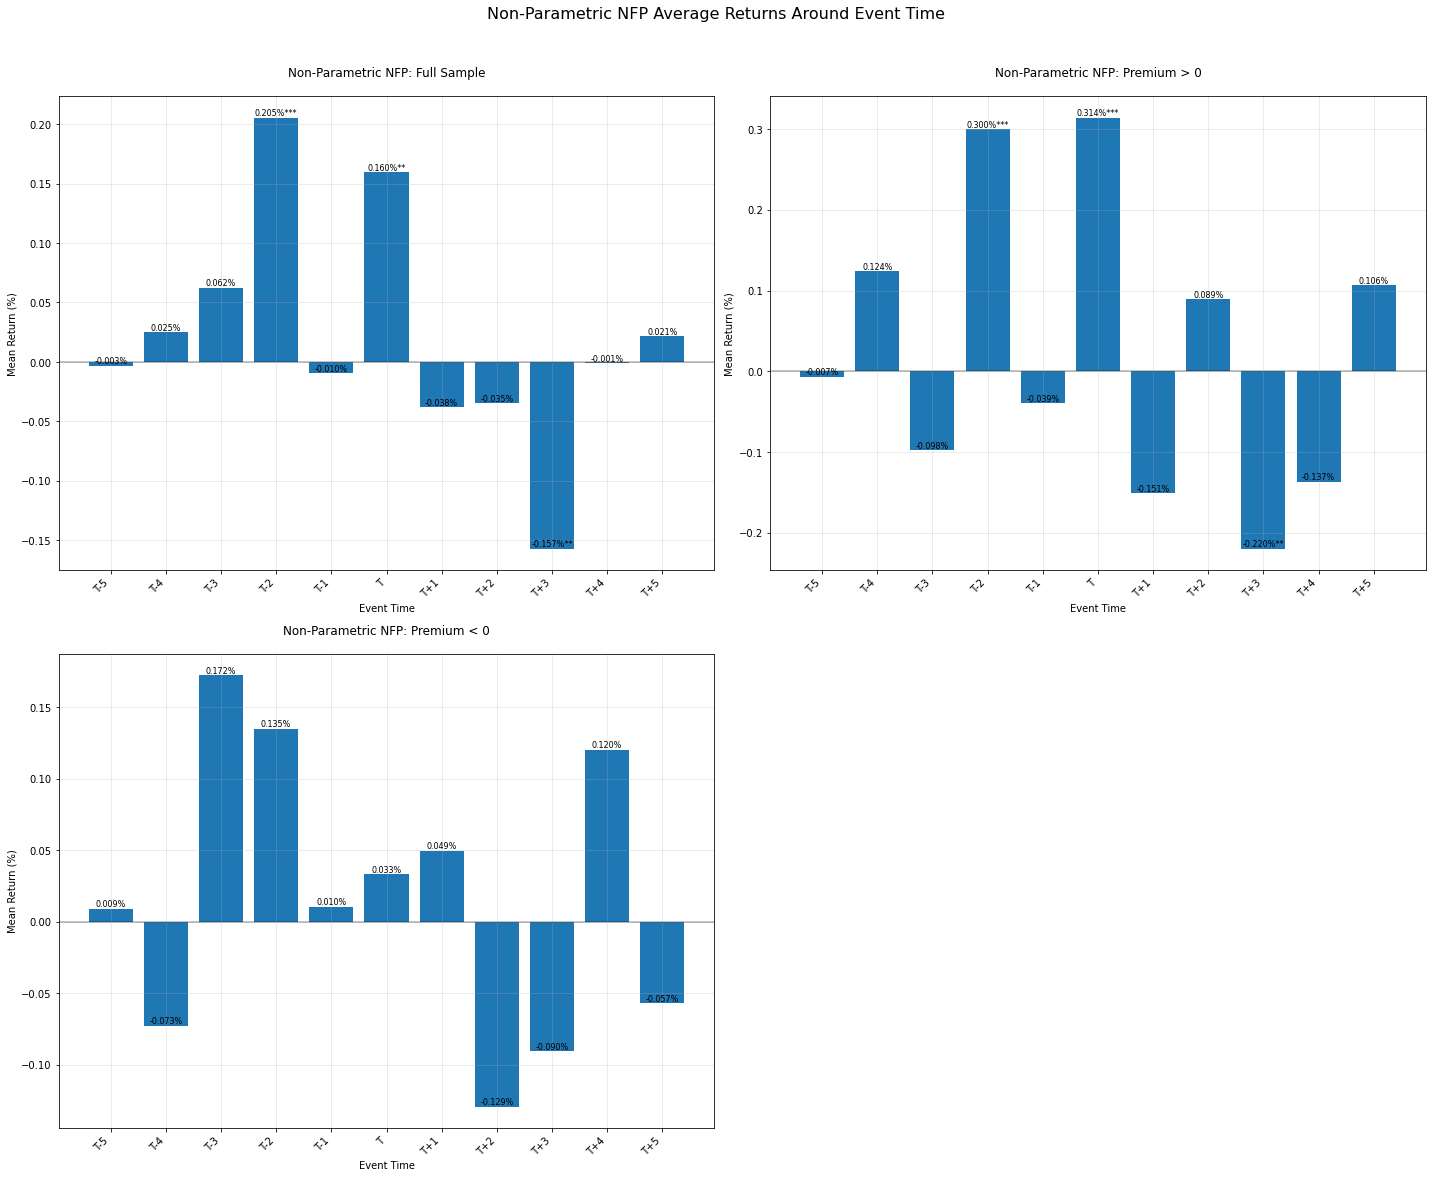


Non-Parametric NFP Full Sample:
      Mean Return    Std Dev      N t-statistic p-value
T-5    -0.003055%  1.068013%  273.0     -0.0473  0.9623
T-4     0.025050%  1.407463%  273.0      0.2941  0.7689
T-3     0.062312%  1.298568%  274.0      0.7943  0.4277
T-2  0.205399%***  1.142540%  274.0      2.9758  0.0032
T-1    -0.009539%  1.191097%  274.0     -0.1326  0.8946
T     0.159659%**  1.276920%  274.0      2.0697  0.0394
T+1    -0.038274%  1.344036%  274.0     -0.4714  0.6378
T+2    -0.034619%  1.252317%  274.0     -0.4576  0.6476
T+3  -0.157232%**  1.165286%  274.0     -2.2335  0.0263
T+4    -0.001282%  1.444125%  274.0     -0.0147  0.9883
T+5     0.021481%  1.207153%  274.0      0.2946  0.7686

Non-Parametric NFP Premium > 0:
      Mean Return    Std Dev      N t-statistic p-value
T-5    -0.006589%  0.994629%  120.0     -0.0726  0.9423
T-4     0.123647%  1.080046%  120.0      1.2541  0.2123
T-3    -0.097737%  1.131373%  120.0     -0.9463  0.3459
T-2  0.300063%***  0.994495%  120.0   

<ipython-input-62-884a5833ad7b>:94: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  with pd.ExcelWriter('period_returns_analysis_event_time_nonparametric_nfp.xlsx') as writer:


<Figure size 432x288 with 0 Axes>

In [62]:
# Keep the same return_list and new_names mapping as before

def calculate_period_returns(data, return_list):
    """
    Calculate average returns for different periods
    """
    period_returns = {}
    
    for return_col in return_list:
        mean = data[return_col].mean()
        std = data[return_col].std()
        count = data[return_col].count()
        
        t_stat, p_value = stats.ttest_1samp(data[return_col].dropna(), 0)
        
        period_returns[new_names[return_col]] = {
            'Mean Return': mean,
            'Std Dev': std,
            'N': count,
            't-statistic': t_stat,
            'p-value': p_value
        }
    
    returns_df = pd.DataFrame(period_returns).T
    
    # Format numbers
    returns_df['Mean Return'] = returns_df['Mean Return'].map('{:.6%}'.format)
    returns_df['Std Dev'] = returns_df['Std Dev'].map('{:.6%}'.format)
    returns_df['t-statistic'] = returns_df['t-statistic'].map('{:.4f}'.format)
    returns_df['p-value'] = returns_df['p-value'].map('{:.4f}'.format)
    
    returns_df['Significance'] = returns_df['p-value'].astype(float).apply(
        lambda x: '***' if x < 0.01 else ('**' if x < 0.05 else ('*' if x < 0.1 else ''))
    )
    
    returns_df['Mean Return'] = returns_df['Mean Return'] + returns_df['Significance']
    returns_df = returns_df.drop('Significance', axis=1)
    
    return returns_df

# Calculate returns for non-parametric conditions with NFP data
conditions_np = {
    'Full Sample': df_nfp,
    'Premium > 0': df_nfp[df_nfp['nfp_diff'] > 0],
    'Premium < 0': df_nfp[df_nfp['nfp_diff'] < 0]
}

# Calculate returns for each condition
results_np = {}
for name, data in conditions_np.items():
    results_np[name] = calculate_period_returns(data, return_list)

# Create subplots (2 rows x 2 columns, but we'll only use 3 plots)
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

# Plot each condition
for i, (name, returns_df) in enumerate(results_np.items()):
    mean_returns = returns_df['Mean Return'].str.rstrip('*').str.rstrip('%').astype(float)
    bars = axes[i].bar(range(len(mean_returns)), mean_returns)
    axes[i].set_title(f'Non-Parametric NFP: {name}', fontsize=12, pad=20)
    axes[i].set_xlabel('Event Time', fontsize=10)
    axes[i].set_ylabel('Mean Return (%)', fontsize=10)
    axes[i].set_xticks(range(len(mean_returns)))
    axes[i].set_xticklabels(returns_df.index, rotation=45, ha='right')
    axes[i].grid(True, alpha=0.3)
    axes[i].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    for j, bar in enumerate(bars):
        height = bar.get_height()
        significance = returns_df['Mean Return'].str.extract(r'([*]+)$').iloc[j, 0]
        significance = '' if pd.isna(significance) else significance
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}%{significance}',
                ha='center', va='bottom', fontsize=8)

# Remove the empty subplot
fig.delaxes(axes[-1])

plt.suptitle('Non-Parametric NFP Average Returns Around Event Time', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('period_returns_analysis_event_time_nonparametric_nfp.png', dpi=300, bbox_inches='tight')

# Print results
for name, returns_df in results_np.items():
    print(f"\nNon-Parametric NFP {name}:")
    print("=" * 80)
    print(returns_df)

# Save to Excel
with pd.ExcelWriter('period_returns_analysis_event_time_nonparametric_nfp.xlsx') as writer:
    for name, returns_df in results_np.items():
        returns_df.to_excel(writer, sheet_name=f'NFP_{name[:28]}')